In [3]:
import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import implicit 
import matplotlib.pyplot as plt
import seaborn as sns
# NEED TO Pip install implicit

C:\Users\daode\OneDrive\Documents\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
twitch = pd.read_csv("100k_a.csv")
twitch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051732 entries, 0 to 3051731
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   1            int64 
 1   33842865744  int64 
 2   mithrain     object
 3   154          int64 
 4   156          int64 
dtypes: int64(4), object(1)
memory usage: 116.4+ MB


In [5]:
twitch.columns = ['userID', 'streamID', 'streamerName', 'StartTime', 'StopTime']
twitch.head(20)

,userID,streamID,streamerName,StartTime,StopTime
0,1,33846768288,alptv,166,169
1,1,33886469056,mithrain,587,588
2,1,33887624992,wtcn,589,591
3,1,33890145056,jrokezftw,591,594
4,1,33903958784,berkriptepe,734,737
5,1,33929318864,kendinemuzisyen,1021,1036
6,1,33942837056,wtcn,1165,1167
7,1,33955351648,kendinemuzisyen,1295,1297
8,1,34060922080,mithrain,2458,2459
9,1,34062621584,unlostv,2454,2456


In [6]:
new_twitch = twitch.groupby(['userID', 'streamerName']).size().reset_index()
new_twitch.columns = ['userID','streamerName', 'interactions']
new_twitch.head()

,userID,streamerName,interactions
0,1,alptv,1
1,1,berkriptepe,1
2,1,elraenn,2
3,1,eraymaskulen,1
4,1,esl_csgo,1


In [7]:
popular = twitch['streamerName'].value_counts().head(20).reset_index()
popular.columns = ['streamerName', 'interactions']
popular.head()

,streamerName,interactions
0,ninja,45144
1,tfue,40136
2,shroud,27362
3,riotgames,17633
4,sodapoppin,14590


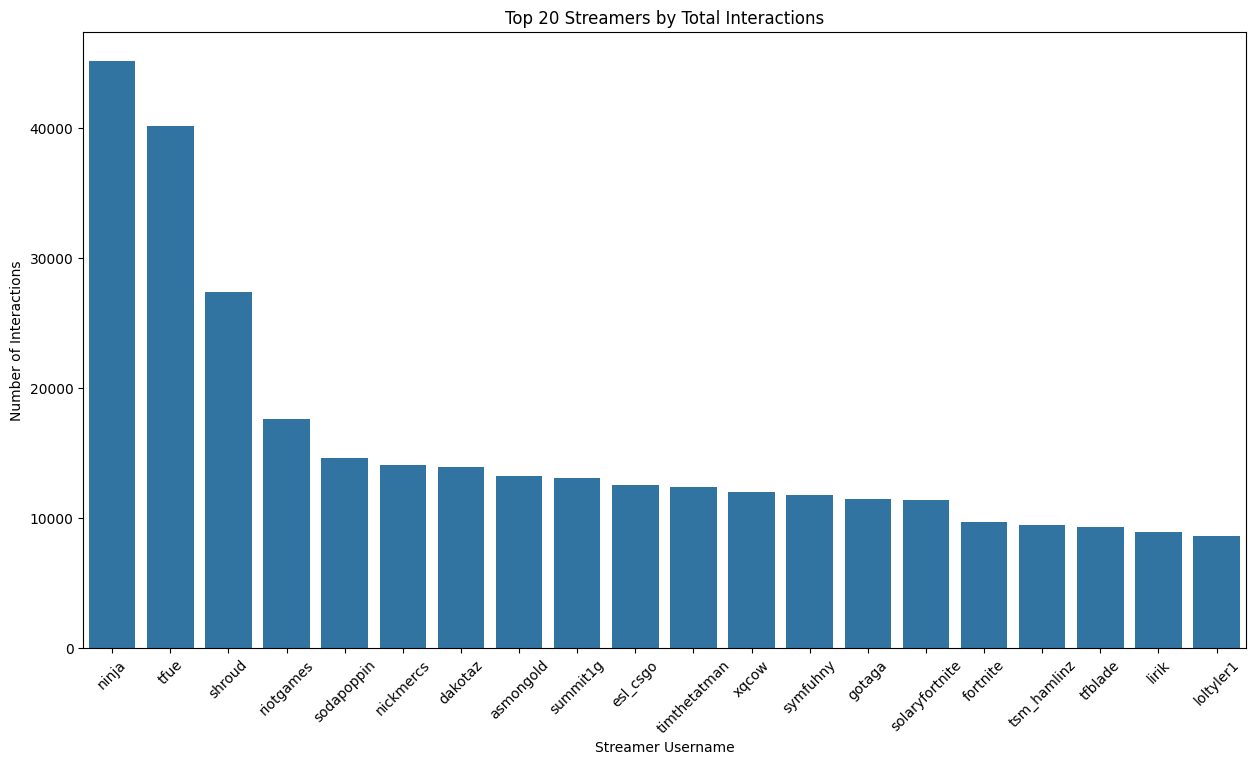

In [8]:
plt.figure(figsize=(15, 8))
sns.barplot(x='streamerName', y='interactions', data=popular)
plt.xticks(rotation=45)
plt.xlabel('Streamer Username')
plt.ylabel('Number of Interactions')
plt.title('Top 20 Streamers by Total Interactions')
plt.show()


In [9]:
new_twitch.shape

(1505158, 3)

In [10]:
num_users = new_twitch.userID.unique()
user_ids = dict(zip(num_users, np.arange(num_users.shape[0], dtype=np.int32)))
num_streamers = new_twitch.streamerName.unique()
streamer_ids = dict(zip(num_streamers, np.arange(num_streamers.shape[0], dtype=np.int32)))

In [11]:
new_twitch['user_ID'] = new_twitch.userID.apply(lambda i: user_ids[i])
new_twitch['streamer_id'] = new_twitch.streamerName.apply(lambda i: streamer_ids[i])

In [12]:
sparse_streamer_user = sparse.csr_matrix((new_twitch['interactions'].astype(float), (new_twitch['streamer_id'], new_twitch['user_ID'])))
sparse_user_streamer = sparse.csr_matrix((new_twitch['interactions'].astype(float), (new_twitch['user_ID'], new_twitch['streamer_id'])))

In [13]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)
alpha = 15
data = (sparse_streamer_user * alpha).astype('double')
model.fit(data)

C:\Users\daode\OneDrive\Documents\anaconda3\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


In [14]:
new_twitch.head(20)

,userID,streamerName,interactions,user_ID,streamer_id
0,1,alptv,1,0,0
1,1,berkriptepe,1,0,1
2,1,elraenn,2,0,2
3,1,eraymaskulen,1,0,3
4,1,esl_csgo,1,0,4
5,1,grimnax,2,0,5
6,1,h3x_tv,1,0,6
7,1,jahrein,3,0,7
8,1,jrokezftw,2,0,8
9,1,jtgtv,2,0,9


In [18]:
user_id = 0
n_similar = 5

streamer_vecs = model.item_factors
user_vecs = model.user_factors

item_norms = np.sqrt((streamer_vecs * streamer_vecs).sum(axis=1))

scores = streamer_vecs.dot(streamer_vecs[user_id]) / item_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[user_id]), key=lambda x: -x[1])

for item in similar:
    idx, score = item
    print(new_twitch.streamerName.loc[new_twitch.streamer_id == idx].iloc[0], " with simalarity score: " , score)

alptv  with simalarity score:  0.9999999
m4rk_osu  with simalarity score:  0.996835
dennis4134  with simalarity score:  0.99664694
omegalulrtifact  with simalarity score:  0.99664694
fgsquared  with simalarity score:  0.9966432
